In [1]:
!pip install tushare

In [2]:
import tushare as ts
import pandas as pd
import os
import numpy as np
import time
from tqdm import tqdm

In [ ]:
"""
获取BP历史数据
"""

wfc_token = '72a3fb11aa9d09b4dbe8019bc6925c5319c27fff1c8a3e5715c72006'
ts.set_token(wfc_token)
save_path = 'stock'
pro = ts.pro_api(wfc_token)

def get_BP_data():
    ## 此函数获得股票池的1/BP（频率：天）的数据，并将所有股票单独保存在一个csv里

    #获取基础信息数据，包括股票代码、名称、上市日期、退市日期等
    ## pool = pro.stock_basic(exchange='',
    ##                       list_status='L',
    ##                       adj='qfq',
    ##                       fields='ts_code,symbol,name,area,industry,fullname,list_date, market,exchange,is_hs')
    ## print(pool.head())
    
    ## 由题给要求，我们使用沪深300作为选股池
    pool = ts.get_hs300s()


    # 根据basic的信息选取板块获取股票池
    ## pool = pool[pool['market'].isin(['科创板'])].reset_index()
    
    print('需爬取股票总数：', len(pool)+1)
    j = 1
    for i in pool.code:
        print('正在获取第%d家，股票代码%s.SZ' % (j, i))
        if j==1:
          df = pro.daily_basic(ts_code=i+'.SZ', start_date=startdate, end_date=enddate, 
                               fields='ts_code,trade_date,turnover_rate,volume_ratio,pe,pb')
          if len(df)!=0:
            industry = pro.stock_basic(ts_code = i+'.SZ',exchange='', list_status='L', fields='industry')['industry'][0]
            df['industry'] = industry
        else:
          df2 = pro.daily_basic(ts_code=i+'.SZ', start_date=startdate, end_date=enddate, 
                                    fields='ts_code,trade_date,close, turnover_rate,volume_ratio,pe,pb')
          if len(df2)!=0:
            industry = pro.stock_basic(ts_code = i+'.SZ',exchange='', list_status='L', fields='industry')['industry'][0]
            df2['industry'] = industry
            df = df.append(df2)
        
        j += 1
    #设定双重重索引的数据格式
    df=df.set_index(['trade_date','ts_code'])
    #根据第一索引排序
    df=df.sort_index()
    path = os.path.join('BP_Data.csv')
    df.to_csv(path, index=True)
    return df

if __name__ == '__main__':
    #设置起始日期
    startdate = '20160101'
    enddate = '20210101'
    #主程序
    get_BP_data()

In [12]:
## bp单因子回测数据整理
raw_data = pd.read_csv('BP_Data.csv')
raw_data['bp'] = 1/raw_data['pb']
input_data = raw_data[['trade_date','ts_code','close','bp','industry']]
input_data

,trade_date,ts_code,close,bp,industry
0,20160104,000001.SZ,11.33,0.969274,银行
1,20160104,000063.SZ,16.92,0.493267,通信设备
2,20160104,000069.SZ,7.95,0.519373,旅游景点
3,20160104,000100.SZ,3.88,0.507125,元器件
4,20160104,000157.SZ,4.96,1.038098,工程机械
...,...,...,...,...,...
130925,20201231,300498.SZ,18.23,0.402658,农业综合
130926,20201231,300529.SZ,67.82,0.047112,医疗保健
130927,20201231,300601.SZ,174.50,0.058135,生物制药
130928,20201231,300628.SZ,73.12,0.073838,通信设备


In [55]:
"""
建立单因子回测框架
"""
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


class one_feature_backtest():
    def __init__(self, input_data, ad_cycle, feature_column, begin_date, end_date):
      ''' Adjustment cycle 调仓周期（多少个交易日） '''
      ''' input_data 输入数据必须满足上面的要求 '''
      ''' 必须含有trade_date, ts_code, close, 单因子值 '''
      ''' feature_column是因子名 '''
      ''' 包含开始日期和结束日期'''

      self.data = input_data.copy()
      self.cycle = ad_cycle
      self.feature = feature_column
      self.begin = begin_date
      self.end = end_date

    def win_sor(self, limit):
      ''' 去极值函数'''
      ''' 替换极大或极小的因子值'''
      ''' 本质上修改了数据集'''
      ''' limit =0.1, 替换极大的百分之10数据和极小的百分之10数据'''
      
      self.data[self.feature] = winsorize(self.data[self.feature], limits=[limit, limit])

    def neutralize(self, MinMaxScaler_or_StandardScaler):
      ''' 根据不同行业对因素值进行中心化 '''
      ''' 提供两种办法，选择一种，若=0，选择MinMaxScaler'''
      ''' 若=1，选择StandardScaler'''
      
      if MinMaxScaler_or_StandardScaler == 0:
        new_data = pd.DataFrame()
        for industry in set(self.data['industry']):
          subset = self.data[self.data['industry'] == industry].copy()
          min_max_scaler = MinMaxScaler()
          subset[self.feature] = min_max_scaler.fit_transform(np.array(subset[self.feature]).reshape(-1,1))
          new_data = new_data.append(subset)   
        self.data = new_data
      else:
        new_data = pd.DataFrame()
        for industry in set(self.data['industry']):
          subset = self.data[self.data['industry'] == industry].copy()
          scaler = StandardScaler()
          subset[self.feature] = scaler.fit_transform(np.array(subset[self.feature]).reshape(-1,1))
          new_data = new_data.append(subset)
        self.data = new_data
      self.data = self.data.sort_values(['trade_date','ts_code'])

    def cal_IC_IR(self, group_number = 5):
      ''' 计算因子的IC值'''
      ''' 默认分组数为5'''
      ''' 仅选择目标时间范围内的数据计算IC'''

      valid_data = self.data[self.data['trade_date']>= self.begin]
      valid_data = valid_data[valid_data['trade_date']<= self.end]
      all_date = sorted(list(set(valid_data['trade_date'])))
      
      ## 根据分组数设定边界
      upper = 100*(group_number -1)/group_number
      bottom = 100/group_number
      i = 0
      IC_list = []

      while i<len(all_date)-self.cycle:
        return_list, bp_list = [], []
        date = all_date[i]
        subdata = valid_data[valid_data['trade_date'] == date].copy()
        df_low = subdata[subdata[self.feature]<=np.percentile(subdata[self.feature], upper)].sort_values('ts_code')
        df_high = subdata[subdata[self.feature]>=np.percentile(subdata[self.feature], bottom)].sort_values('ts_code')
        low_bp, high_bp = df_low[self.feature], df_high[self.feature]
        low_comp,high_comp = df_low['ts_code'], df_high['ts_code']
        low_close1, high_close1 = df_low['close'], df_high['close']
        next_date = all_date[i+self.cycle]

        ## 这里的方法是选择了最接近结算日的日期的收盘价，因为结算日可能存在部分股票不交易的行为
        low_close2, high_close2 = [], []
        for comp in low_comp:
          small_df = valid_data[valid_data['ts_code']==comp]
          low_close2.append(list(small_df[small_df['trade_date']<=next_date]['close'])[-1])

        for comp in high_comp:
          small_df = valid_data[valid_data['ts_code']==comp]
          high_close2.append(list(small_df[small_df['trade_date']<=next_date]['close'])[-1])
        
        low_return = list(np.array(low_close2)/np.array(low_close1) - 1)
        high_return = list(np.array(high_close2)/np.array(high_close1) -1)
        return_list.extend(low_return)
        return_list.extend(high_return)
        bp_list.extend(low_bp)
        bp_list.extend(high_bp)
        
        ## 计算return和因子的相关系数
        IC = pd.Series(bp_list).corr(pd.Series(return_list))
        IC_list.append(IC)
        i+=self.cycle
      
      ## 计算IC平均值
      print('IC多周期均值:', np.mean(IC_list))

      ## 计算IR
      print('IR:', np.mean(IC_list)/np.std(IC_list))
    
    def  groups_performance(self, group_number = 5):
      '''根据分组回测获得各组股票组合的收益率的表现'''
      '''默认分组数为5'''

      valid_data = self.data[self.data['trade_date']>= self.begin]
      valid_data = valid_data[valid_data['trade_date']<= self.end]
      all_date = sorted(list(set(valid_data['trade_date'])))

      ## 根据分组数设定分界,如果分组数为5，则有5条线 [20,40,60,80,100]
      lines = [100*i/group_number for i in range(1,group_number+1)]
      i = 0

      ## 记录所有周期的各组收益率
      total_ret_list = []
      cycle_date = []

      while i<len(all_date)-self.cycle:
        return_list, bp_list = [], []
        date = all_date[i]
        cycle_date.append(date)
        subdata = valid_data[valid_data['trade_date'] == date].copy()

        ## 记录当个周期的各组收益率，每组中各股等权重投资
        cycle_ret_list = []
        for j in range(group_number):
          if j==0:
            line = lines[j]
            df = subdata[subdata[self.feature]<=np.percentile(subdata[self.feature], line)].sort_values('ts_code')
          else:
            last_line, line = lines[j-1], lines[j]
            df1 = subdata[subdata[self.feature]<=np.percentile(subdata[self.feature], line)].sort_values('ts_code')
            df = df1[df1[self.feature]>np.percentile(df1[self.feature], last_line)].sort_values('ts_code')
          
          comps = df['ts_code']
          close1 = df['close']
          next_date = all_date[i+self.cycle]

          ## 这里的方法是选择了最接近结算日的日期的收盘价，因为结算日可能存在部分股票不交易的行为
          close2 = []
          for comp in comps:
            small_df = valid_data[valid_data['ts_code']==comp]
            close2.append(list(small_df[small_df['trade_date']<=next_date]['close'])[-1])

          ret = np.mean(list(np.array(close2)/np.array(close1) - 1))
          cycle_ret_list.append(ret)
          
        
        total_ret_list.append(cycle_ret_list)
        i+=self.cycle

      ## 进行各组收益的累乘操作
      cycle_date = [str(date)[2:4] +'-'+str(date)[4:6] for date in cycle_date]
      cumprod_list = []
      for i in range(group_number):
        cumprod_list.append(np.cumprod([e[i]+1 for e in total_ret_list])-1)
      

      plt.style.use('ggplot')
      fig, ax = plt.subplots(1,1)
      for i in range(group_number):
        ax.plot(cycle_date,cumprod_list[i], label ='group' + str(i+1))
        ## 处理日期轴的出现间隔，防止过于密集
        ax.xaxis.set_major_locator(ticker.MultipleLocator(base=int(len(cycle_date)/10)+1))

      plt.legend(loc = 0)
      plt.xlabel('date')
      plt.ylabel('total_return')
      plt.title('Divided by '+str(group_number)+' Groups, cycle=' +str(self.cycle)+' days')
      plt.show()


In [15]:
print('不去极值不中性化后的结果：')
bp_backtest1 = one_feature_backtest(input_data,20,'bp',20160104,20201231)
bp_backtest1.cal_IC_IR()

print('\n去极值不中性化后的结果:')
bp_backtest2 = one_feature_backtest(input_data,20,'bp',20160104,20201231)
bp_backtest2.win_sor(limit = 0.05)
bp_backtest2.cal_IC_IR()

print('\n去极值中性化（方法1）后的结果:')
bp_backtest3 = one_feature_backtest(input_data,20,'bp',20160104,20201231)
bp_backtest3.win_sor(limit = 0.05)
bp_backtest3.neutralize(1)
bp_backtest3.cal_IC_IR()

print('\n去极值中性化（方法2）后的结果:')
bp_backtest4 = one_feature_backtest(input_data,20,'bp',20160104,20201231)
bp_backtest4.win_sor(limit = 0.05)
bp_backtest4.neutralize(0)
bp_backtest4.cal_IC_IR()

print('\n不去极值中性化（方法1）后的结果:')
bp_backtest5 = one_feature_backtest(input_data,20,'bp',20160104,20201231)
bp_backtest5.neutralize(0)
bp_backtest5.cal_IC_IR()


print('\n去极值中性化（方法1）后的结果，并修改换仓周期:')
bp_backtest3 = one_feature_backtest(input_data,100,'bp',20160104,20201231)
bp_backtest3.win_sor(limit = 0.05)
bp_backtest3.neutralize(1)
bp_backtest3.cal_IC_IR()


## 可以看到使用第一种中心化（StandardScaler）的方法, 配合去极值过程后，有着非常不错的结果
## 换仓周期从20改为100后，IC均值和IR均上升，bp因子与收益关系可能是长周期性的
## bp因子是一个十分有效的正向因子。

不去极值不中性化后的结果：
IC多周期均值: 0.007934307703354316
IR: 0.0481777022590795

去极值不中性化后的结果:
IC多周期均值: 0.009559800083891694
IR: 0.05630657602881667

去极值中性化（方法1）后的结果:
IC多周期均值: 0.055175469510555616
IR: 0.41122005610551265

去极值中性化（方法2）后的结果:
IC多周期均值: 0.019909590102780525
IR: 0.12834543300658488

不去极值中性化（方法1）后的结果:
IC多周期均值: 0.037165785441864704
IR: 0.2793187133208886

去极值中性化（方法1）后的结果，并修改换仓周期:
IC多周期均值: 0.09729003918534203
IR: 0.6987168322347667


调仓周期为100天：


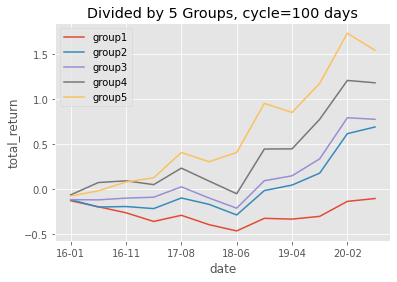

调仓周期为50天：


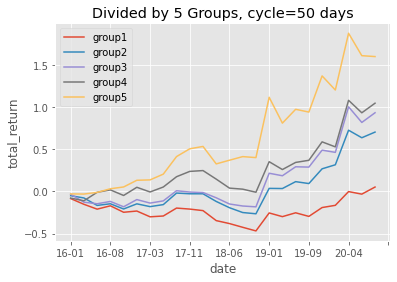

调仓周期为30天：


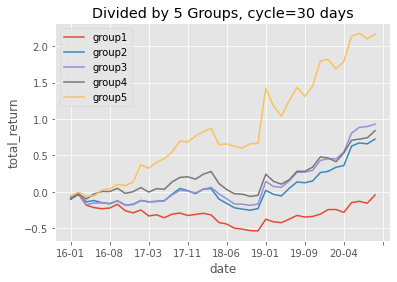

调仓周期为20天：


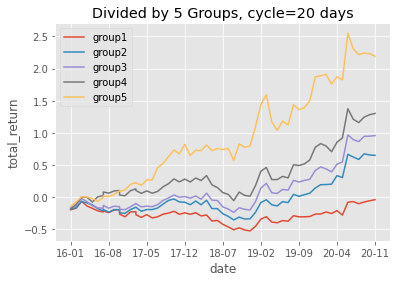

调仓周期为10天：


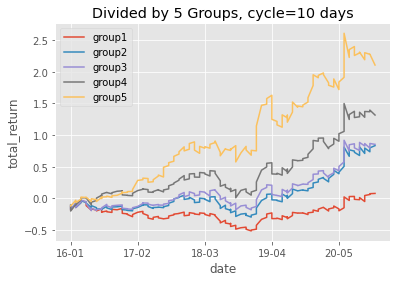

In [56]:
## 分组收益表现
print('调仓周期为100天：')
bp_backtest3 = one_feature_backtest(input_data,100,'bp',20160104,20201231)
bp_backtest3.win_sor(limit = 0.05)
bp_backtest3.neutralize(1)
bp_backtest3.groups_performance()

print('调仓周期为50天：')
bp_backtest3 = one_feature_backtest(input_data,50,'bp',20160104,20201231)
bp_backtest3.win_sor(limit = 0.05)
bp_backtest3.neutralize(1)
bp_backtest3.groups_performance()

print('调仓周期为30天：')
bp_backtest3 = one_feature_backtest(input_data,30,'bp',20160104,20201231)
bp_backtest3.win_sor(limit = 0.05)
bp_backtest3.neutralize(1)
bp_backtest3.groups_performance()

print('调仓周期为20天：')
bp_backtest3 = one_feature_backtest(input_data,20,'bp',20160104,20201231)
bp_backtest3.win_sor(limit = 0.05)
bp_backtest3.neutralize(1)
bp_backtest3.groups_performance()


print('调仓周期为10天：')
bp_backtest3 = one_feature_backtest(input_data,10,'bp',20160104,20201231)
bp_backtest3.win_sor(limit = 0.05)
bp_backtest3.neutralize(1)
bp_backtest3.groups_performance()

In [ ]:
"""
跟踪聪明钱复现
获取分钟历史数据，股票池：上证300
同样使用之前的tushare数据获取模板
"""

"""
获取BP历史数据
"""

wfc_token = '72a3fb11aa9d09b4dbe8019bc6925c5319c27fff1c8a3e5715c72006'
ts.set_token(wfc_token)
save_path = 'stock'
pro = ts.pro_api(wfc_token)

def get_minite_data():
    ## 此函数获得股票池的交易（频率：分钟）的数据，并将所有股票单独保存在一个csv里

    #获取基础信息数据，包括股票代码、名称、上市日期、退市日期等
    ## pool = pro.stock_basic(exchange='',
    ##                       list_status='L',
    ##                       adj='qfq',
    ##                       fields='ts_code,symbol,name,area,industry,fullname,list_date, market,exchange,is_hs')
    ## print(pool.head())
    
    ## 由题给要求，我们使用沪深300作为选股池
    pool = ts.get_hs300s()


    # 根据basic的信息选取板块获取股票池
    ## pool = pool[pool['market'].isin(['科创板'])].reset_index()
    
    print('需爬取股票总数：', len(pool)+1)
    j = 1
    for i in pool.code:
        print('正在获取第%d家，股票代码%s.SZ' % (j, i))
        if j==1:
          df = ts.pro_bar(ts_code=i+'.SZ', start_date=startdate, end_date=enddate, freq = 'min')
          if len(df)!=0:
            industry = pro.stock_basic(ts_code = i+'.SZ',exchange='', list_status='L', fields='industry')['industry'][0]
            df['industry'] = industry
        else:
          df = ts.pro_bar(ts_code=i+'.SZ', start_date=startdate, end_date=enddate, freq = 'min')
          if len(df2)!=0:
            industry = pro.stock_basic(ts_code = i+'.SZ',exchange='', list_status='L', fields='industry')['industry'][0]
            df2['industry'] = industry
            df = df.append(df2)
        
        j += 1
    #设定双重重索引的数据格式
    df=df.set_index(['trade_date','ts_code'])
    #根据第一索引排序
    df=df.sort_index()
    path = os.path.join('minute_Data.csv')
    df.to_csv(path, index=True)
    return df

if __name__ == '__main__':
    #设置起始日期
    startdate = '2020-01-01 09:00:00'
    enddate = '2020-01-04 16:00:00'
    #主程序
    get_minite_data()